In [1]:
# Imports
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

# load_data.py

In [3]:
# Imports
import numpy as np

from tqdm import tqdm

import cv2
import glob
import sys

import os

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return cv2.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split(os.sep)
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    files = get_files(folder)
    images = []
    tqdm_iter = tqdm(files)
    tqdm_iter.set_description("Image Data Loaded -> ")
    for index, f in enumerate(tqdm_iter):
        img_arr = get_img_array(f)
        images.append(img_arr)
    X = np.array(images)
    return X

def get_labels(folder, label2id):
    files = get_files(folder)
    y = []
    tqdm_iter = tqdm(files)
    tqdm_iter.set_description("Label Data Loaded -> ")
    for index, f in enumerate(tqdm_iter):
        y.append(get_label(f,label2id))
    y = np.array(y)

    return y

def get_images_and_labels(folder, label2id):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """ 

    return get_images(folder), get_labels(folder,label2id)

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = os.path.join(data_root_path, 'train')
    id2label, label2id = get_label_mapping(os.path.join(data_root_path,'labels.txt'))
    print(label2id)
    print('Loading training data')
    X, y = get_images_and_labels(train_data_path,label2id)
    print('Training data loaded.\n')
    return X, y

def train_val_split(X, y, training_rate=0.8):
    n = X.shape[0]
    num = int(n * training_rate)
    print('Split training/validation data->training:{}, validation:{}'.format(num, n - num))
    print('Splitting done')
    return X[0:num], y[0:num], X[num:], y[num:]

# cnn_model.py

In [4]:
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""

  origin_images = features["x"]

  # Randomly flip the image horizontally.
  distorted_images = tf.map_fn(lambda image:tf.image.random_flip_left_right(image),origin_images)

  # Because these operations are not commutative, consider randomizing
  # the order their operation.
  # NOTE: since per_image_standardization zeros the mean and makes
  # the stddev unit, this likely has no effect see tensorflow#1458.
  distorted_images = tf.image.random_brightness(distorted_images,
                                             max_delta=63)
  distorted_images = tf.image.random_contrast(distorted_images,
                                           lower=0.2, upper=1.8)
  # Subtract off the mean and divide by the variance of the pixels.
  float_image = tf.map_fn(lambda distorted_image:tf.image.per_image_standardization(distorted_image),distorted_images)
  
  # Input Layer
  input_layer = tf.reshape(float_image, [-1, 32, 32, 3])

  # Convolutional Layer #1
  # Input:  [-1,32,32,3]
  # Output: [-1,32,32,32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # Input: [-1,32,32,32]
  # Output: [-1,16,16,32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
  # Norm #1
  norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm1')

  # Convolutional Layer #2, Norm#2 and Pooling Layer #2
  # Input: [-1,16,16,32]
  # Output: [-1,16,16,64]
  conv2 = tf.layers.conv2d(
      inputs=norm1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  

  # norm2
  norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,
                    name='norm2')
  # Input: [-1,16,16,64]
  # Output: [-1,8,8,64]
  pool2 = tf.layers.max_pooling2d(inputs=norm2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# Load data

In [5]:
DATA_ROOT_PATH = os.path.join('data','HW2_data')

In [6]:
X, y = get_train_data(DATA_ROOT_PATH)
X = np.asarray(X,dtype=np.float32)
X_train, y_train, X_val, y_val = train_val_split(X, y)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loading training data


Image Data Loaded -> : 100%|████████████████████████████████████████████████████| 45000/45000 [01:07<00:00, 670.89it/s]


Training data loaded.

Split training/validation data->training:36000, validation:9000
Splitting done


# Model Creation

In [7]:
cifar_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="cifar_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cifar_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002A97A8FC6A0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Train Model

In [22]:
TRAINING_NUM = X_train.shape[0]
BATCH_SIZE = 200
EPOCH = int(TRAINING_NUM / BATCH_SIZE)
STEP = 10000

In [23]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    batch_size=BATCH_SIZE,
    num_epochs=None,
    shuffle=True)
cifar_classifier.train(
  input_fn=train_input_fn,
  steps=STEP)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into cifar_convnet_model\model.ckpt.
INFO:tensorflow:loss = 2.4306183, step = 1
INFO:tensorflow:global_step/sec: 7.95904
INFO:tensorflow:loss = 1.4682717, step = 101 (12.566 sec)
INFO:tensorflow:global_step/sec: 8.02918
INFO:tensorflow:loss = 1.155845, step = 201 (12.456 sec)
INFO:tensorflow:global_step/sec: 8.03512
INFO:tensorflow:loss = 0.99652874, step = 301 (12.445 sec)
INFO:tensorflow:global_step/sec: 8.07936
INFO:tensorflow:loss = 1.1275859, step = 401 (12.375 sec)
INFO:tensorflow:global_step/sec: 8.03271
INFO:tensorflow:loss = 0.98840696, step = 501 (12.450 sec)
INFO:tensorflow:global_step/sec: 8.06424
INFO:tensorflow:loss = 0.88176656, step = 601 (12.399 sec)
INFO:tensorflow:global_step/sec: 8.02737
INFO:tensorflow:loss = 0.8220659, step = 701 (12.458 sec)
INFO:tensorflow:global_step/sec: 8.05537
INFO:tensorflow:loss = 0.86434203, step = 801 (12.414 sec)
INFO:tensorflow:global_step/sec: 8.08093

INFO:tensorflow:global_step/sec: 8.16406
INFO:tensorflow:loss = 0.04185932, step = 8001 (12.260 sec)
INFO:tensorflow:global_step/sec: 8.13135
INFO:tensorflow:loss = 0.08159888, step = 8101 (12.287 sec)
INFO:tensorflow:global_step/sec: 8.1951
INFO:tensorflow:loss = 0.13179916, step = 8201 (12.202 sec)
INFO:tensorflow:global_step/sec: 8.18346
INFO:tensorflow:loss = 0.033807296, step = 8301 (12.221 sec)
INFO:tensorflow:global_step/sec: 8.17597
INFO:tensorflow:loss = 0.083298214, step = 8401 (12.230 sec)
INFO:tensorflow:global_step/sec: 8.1742
INFO:tensorflow:loss = 0.07325071, step = 8501 (12.235 sec)
INFO:tensorflow:global_step/sec: 8.12173
INFO:tensorflow:loss = 0.074727125, step = 8601 (12.312 sec)
INFO:tensorflow:global_step/sec: 8.18434
INFO:tensorflow:loss = 0.107841544, step = 8701 (12.219 sec)
INFO:tensorflow:global_step/sec: 8.19501
INFO:tensorflow:loss = 0.08380856, step = 8801 (12.203 sec)
INFO:tensorflow:global_step/sec: 8.1877
INFO:tensorflow:loss = 0.113780916, step = 8901 (

# Evaluation Model

## Training Dataset Evaluation

In [8]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train},
    y=y_train,
    num_epochs=1,
    shuffle=False)
eval_results = cifar_classifier.evaluate(input_fn=eval_input_fn)
print('Training evaluation:')
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-02-24-04:53:38
INFO:tensorflow:Restoring parameters from cifar_convnet_model\model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-02-24-04:54:00
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9892222, global_step = 10000, loss = 0.03503163
Training evaluation:
{'accuracy': 0.9892222, 'loss': 0.03503163, 'global_step': 10000}


## Validation Dataset Evaluation

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_val},
    y=y_val,
    num_epochs=1,
    shuffle=False)
eval_results = cifar_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-02-24-04:54:04
INFO:tensorflow:Restoring parameters from cifar_convnet_model\model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-02-24-04:54:07
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.7416667, global_step = 10000, loss = 1.562453
{'accuracy': 0.7416667, 'loss': 1.562453, 'global_step': 10000}


# Prediction

In [10]:
TEST_PATH = os.path.join(DATA_ROOT_PATH, 'test')
ID2LABEL, _ = get_label_mapping(os.path.join(DATA_ROOT_PATH,'labels.txt'))
MAX_IMG = 10
IMG_ROW = 2
IMG_COL = MAX_IMG / IMG_ROW
OUTPUT_FILE = 'submit.csv'

## Load Test Data

In [11]:
X_test = get_images(TEST_PATH).astype(dtype=np.float32)
filenames = get_files(TEST_PATH)

Image Data Loaded -> : 100%|██████████████████████████████████████████████████████| 5000/5000 [00:09<00:00, 528.96it/s]


## Predict Result

INFO:tensorflow:Restoring parameters from cifar_convnet_model\model.ckpt-10000


Predicted -> : 100%|██████████████████████████████████████████████████████████████| 5000/5000 [00:08<00:00, 618.93it/s]


,id,label
0,0,horse
1111,1,automobile
2222,2,deer
3333,3,automobile
4444,4,airplane
4556,5,bird
4667,6,bird
4778,7,dog
4889,8,truck
1,9,frog


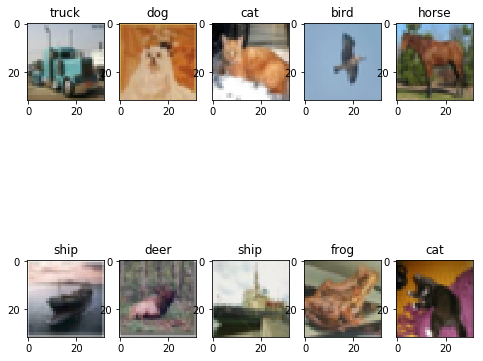

In [13]:
# set prediction tensors
pred_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test},y=None, num_epochs=1, shuffle=False)
predictions = cifar_classifier.predict(input_fn=pred_input_fn)

# sample plot
fig=plt.figure(figsize=(8, 8))

# dataframe to store and save results
df = pd.DataFrame(columns=['id','label'])

# prediction progress bar
tqdm_iter = tqdm(list(zip(predictions,filenames)))
tqdm_iter.set_description('Predicted -> ')

# image count
img_count = 0

# iterations
for index, (prediction, filename) in enumerate(tqdm_iter):
    # extract picture id
    pic_id = int(filename.split(os.sep)[-1].split('.')[0])
    
    # extract label
    label = ID2LABEL[prediction['classes']]
    
    # store information
    df = df.append({'id':pic_id - 1,'label':label},ignore_index=True,verify_integrity=True)
    
    # plot first MAX_IMG images
    if img_count < MAX_IMG and np.random.random() >= 0.9:
        img_count += 1
        img=mpimg.imread(filename)
        fig.add_subplot(IMG_ROW, IMG_COL, img_count)
        plt.title(label)
        plt.imshow(img)

# sort by picture id
df = df.sort_values(by=['id'])

# save values into csv file
df.to_csv(OUTPUT_FILE,index=False)

# show
df